## Objective
Run algorithm on spikeinterface recording

si_rec6.ipynb -> si_rec7.ipynb: Sequence detection is the same as spike assignment

NOTE: If something missing in this (such as saving coc dict pickles), go back to si_rec5.py

## Globals setup

In [1]:
%load_ext autoreload

In [2]:
from copy import deepcopy
from importlib import reload
from multiprocessing import Pool
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

%autoreload 2
from src import utils
from src.run_alg import si_rec7 as F  # This forces you to manually reload every time modification happens (prevents forgetfulness errors)
from src.sorters.base import Unit

In [3]:
# TRAINING_FRAMES for forming sequences while TESTING_FRAMES if for comparing with kilosort
# CALLED FRAMES BUT IS ACTUALLY IN ms
TRAINING_FRAMES = (0, 5*60*1000)  # 0 min to 5 min in recording (in ms)
TESTING_FRAMES = (5*60*1000, 10*60*1000)  # 5 min to 10 min in recording (in ms)

In [4]:
RECORDING = utils.rec_si()
CHANS_RMS = utils.chans_rms_si()

SAMP_FREQ = RECORDING.get_sampling_frequency()
NUM_ELECS = RECORDING.get_num_channels()
ELEC_LOCS = RECORDING.get_channel_locations()

COC_DICT_ROOT = Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/coc_dicts")

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


Recording does not have scaled traces. Setting gain to 0.195


In [5]:
ALL_CLOSEST_ELECS = []
for elec in range(NUM_ELECS):
    elec_ind = []
    dists = []
    x1, y1 = ELEC_LOCS[elec]
    for elec2 in range(RECORDING.get_num_channels()):
        if elec == elec2:
            continue
        x2, y2 = ELEC_LOCS[elec2]
        dists.append(np.sqrt((x2 - x1)**2 + (y2 - y1)**2))
        elec_ind.append(elec2)
    order = np.argsort(dists)
    ALL_CLOSEST_ELECS.append(np.array(elec_ind)[order])   

In [6]:
ALL_CROSSINGS = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/all_crossings.npy", allow_pickle=True)
ALL_CROSSINGS = [tuple(cross) for cross in ALL_CROSSINGS]

ELEC_CROSSINGS_IND = np.load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/prop_signal/elec_crossings_ind.npy", allow_pickle=True)
ELEC_CROSSINGS_IND = [tuple(ind) for ind in ELEC_CROSSINGS_IND]  # [(elec's cross times ind in all_crossings)]

In [7]:
TRACES_FILT_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/traces_filt.npy"
MODEL_OUTPUTS_PATH = "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/outputs.npy"
FRONT_BUFFER = 40  # Model's front sample buffer

In [26]:
# Set global variables in .py
reload(F)

F.RECORDING = RECORDING
F.CHANS_RMS = CHANS_RMS
F.SAMP_FREQ = SAMP_FREQ
F.NUM_ELECS = NUM_ELECS
F.ELEC_LOCS = ELEC_LOCS
F.COC_DICT_ROOT = COC_DICT_ROOT

F.ALL_CLOSEST_ELECS = ALL_CLOSEST_ELECS

F.ALL_CROSSINGS = ALL_CROSSINGS
F.ELEC_CROSSINGS_IND = ELEC_CROSSINGS_IND

F.TRACES_FILT_PATH = TRACES_FILT_PATH
F.MODEL_OUTPUTS_PATH = MODEL_OUTPUTS_PATH
F.FRONT_BUFFER = FRONT_BUFFER

F.TRACES = np.load(TRACES_FILT_PATH, mmap_mode="r")
F.OUTPUTS = np.load(MODEL_OUTPUTS_PATH, mmap_mode="r")

## Detect sequences
partial_sequences = get_partial_sequences(root_elec, time_frame, min_num_coacs=, min_coac_prob=, max_latency_diff=, max_rel_amp_diff=, max_amp_diff=)
full_sequences = merge_sequences(partial_sequences, max_std_diff=)

### Development

In [9]:
%autoreload 2
from src.sorters.kilosort import get_experts_kilosort
from src.comparison import Comparison
kilosort = get_experts_kilosort(testing_ms=TRAINING_FRAMES)

/data/MEAprojects/PropSignal/src/sorters/kilosort.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array([spikes1[idx] for idx in range(len(comp.match12)) if comp.match12[idx] != -1])


Recording does not have scaled traces. Setting gain to 0.195


In [12]:
Comparison.count_all_overlaps(kilosort.get_spike_times(), [p._spike_train for p in all_sequences])

0.5875460926939088
0.8237142283937349


In [81]:
ref_elec = 0
partial_sequences = F.get_partial_sequences(ref_elec, TRAINING_FRAMES, 
                                            verbose=True)
print(len(partial_sequences))
print(sum(len(p._spike_train) for p in partial_sequences))


  2%|▏         | 142/9008 [00:00<00:12, 706.12it/s]

100%|██████████| 9008/9008 [00:12<00:00, 721.21it/s]

37
1285


In [74]:
full_sequences = F.merge_sequences(deepcopy(partial_sequences), verbose=True, max_amp_median_diff=0.4)
print(len(full_sequences))

Starting with 37 partial sequences
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Ending with 3 sequences
3


In [75]:
np.sort([len(s._spike_train) for s in full_sequences])

array([ 34, 228, 970])

In [79]:
cluster_i = full_sequences[0]
cluster_j = full_sequences[-1]

elec_weights = cluster_i.get_elec_weights(cluster_j.elec_probs, start_idx=1)
latencies_diffs = cluster_i.latencies - cluster_j.latencies
latency_diff = np.sum(np.abs(latencies_diffs) * elec_weights)
print(latency_diff)

elec_weights = cluster_j.get_elec_weights(cluster_j.elec_probs, start_idx=0)
amp_median_div = (cluster_i.amp_medians + cluster_j.amp_medians) / 2
amp_median_diff = np.abs((cluster_i.amp_medians - cluster_j.amp_medians)) / amp_median_div
amp_median_diff = np.sum(amp_median_diff * elec_weights)
print(amp_median_diff)

3.5422995631205216
0.44274786


0.6011448550047165


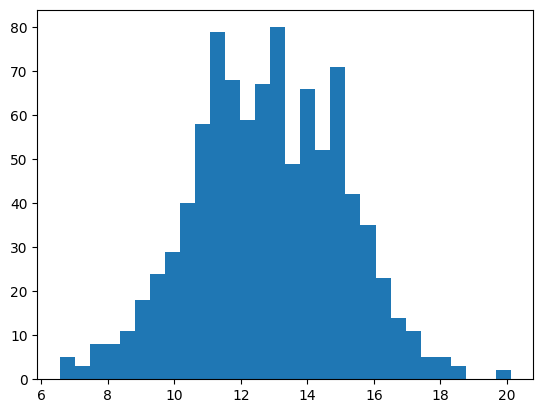

0.9615378670688248


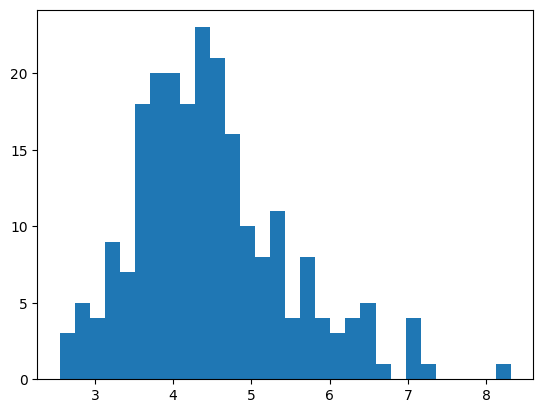

0.7165794467215522


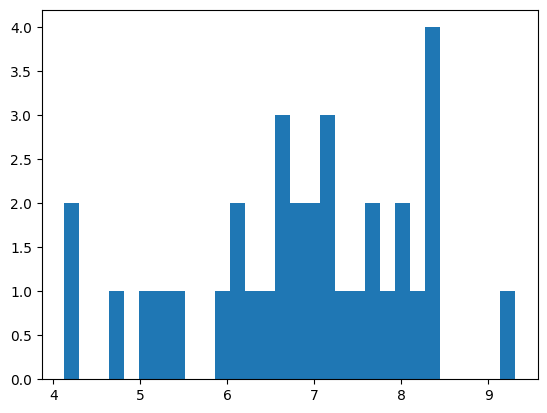

0.8030046374981885


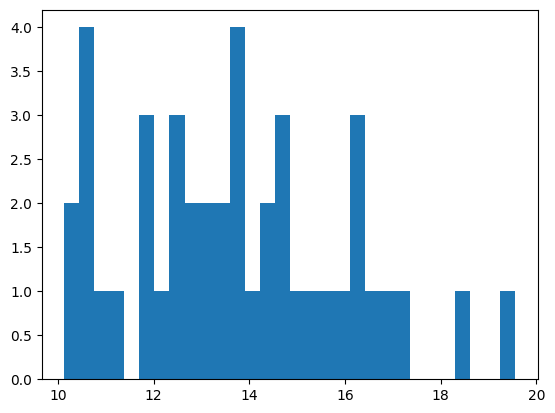

In [62]:
from diptest import diptest
for seq in full_sequences:
    amps = seq.spikes_amp_medians[ref_elec]
    dip, pval = diptest(amps)
    print(pval)
    plt.hist(amps, bins=30)
    plt.show()

--------------------------------------------------
Using templates median


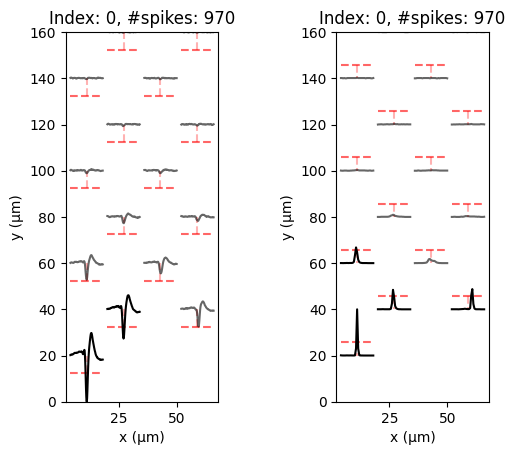

--------------------------------------------------
Using templates median


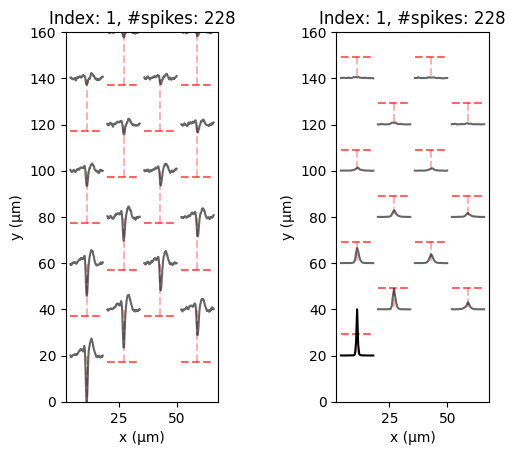

--------------------------------------------------
Using templates median


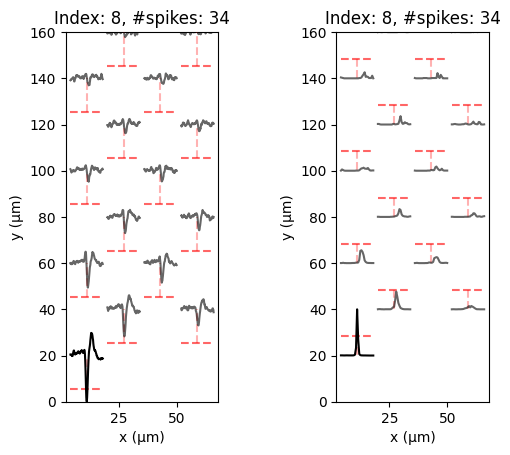

In [78]:
# Look at some partial sequences
np.random.seed(3)
# for seq in np.random.choice(all_sequences, 5, replace=False):
for seq in full_sequences:

# for seq in np.random.choice(full_sequences, size=10):
# for s, seq in enumerate(partial_sequences):
# for s in [87]:
#     seq = partial_sequences[s]
    
    print("-"*50)
    amp_kwargs, prob_kwargs = F.plot_elec_probs(seq, idx=getattr(seq, "idx", 0))
    plt.show()
    
    # amp_medians = [medians[ref_elec] for medians in seq.spikes_amp_medians]
    # plt.hist(amp_medians, bins=30)
    # plt.show()
    
    # for idx, time in enumerate(seq._spike_train):
    # np.random.seed(105)
    # for time in np.random.choice(seq._spike_train, 3):
    #     unit = Unit(0, [time], ref_elec, RECORDING)
    #     unit.root_elecs = [ref_elec]
    #     # F.plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    #     F.plot_elec_probs(unit)
    #     print(time)
    #     plt.show()

In [ ]:
# form_from_root
root_elec=50
time_frame=TRAINING_FRAMES
min_cocs=50
verbose=True

coc_clusters = F.form_coc_clusters(root_elec, time_frame, 1/SAMP_FREQ,
                                 min_cocs=min_cocs, verbose=verbose)

F.setup_coc_clusters(coc_clusters)

F.assign_spikes(coc_clusters, time_frame, verbose=verbose)
coc_clusters = [c for c in coc_clusters if len(c._spike_train) >= min_cocs]

Starting with elec 50, loc: [ 43. 540.]
2742 cocs total

Comparing to elec 52, loc: [ 59. 560.]
Found 7 clusters
2161 cocs remaining
Patience counter: 0/6

Comparing to elec 53, loc: [ 27. 560.]
Found 4 clusters
1746 cocs remaining
Patience counter: 0/6

Comparing to elec 49, loc: [ 27. 520.]
Found 2 clusters
1573 cocs remaining
Patience counter: 0/6

Comparing to elec 48, loc: [ 59. 520.]
Found 1 clusters
1509 cocs remaining
Patience counter: 0/6

Comparing to elec 51, loc: [ 11. 540.]
Found 2 clusters
1283 cocs remaining
Patience counter: 0/6

Comparing to elec 46, loc: [ 43. 500.]
Found 0 clusters
1283 cocs remaining
Patience counter: 1/6

Comparing to elec 54, loc: [ 43. 580.]
Found 2 clusters
1109 cocs remaining
Patience counter: 0/6

Comparing to elec 55, loc: [ 11. 580.]
Found 0 clusters
1109 cocs remaining
Patience counter: 1/6

Comparing to elec 47, loc: [ 11. 500.]
Found 0 clusters
1109 cocs remaining
Patience counter: 2/6

Comparing to elec 44, loc: [ 59. 480.]
Found 0 clust

100%|██████████| 2451452/2451452 [00:44<00:00, 55365.73it/s]


In [ ]:
merges = F.merge_coc_clusters(deepcopy(coc_clusters), verbose=verbose)


Merged 1 with 6
Latency diff: 0.31. Rel amp diff: 0.06
Amp dist p-value 0.7822
#spikes:
Merge base: 78, Add: 157, Overlaps: 0
After merging: 235

Merged [1, 6] with 5
Latency diff: 0.17. Rel amp diff: 0.11
Amp dist p-value 0.9706
#spikes:
Merge base: 235, Add: 83, Overlaps: 0
After merging: 318

Merged 0 with 4
Latency diff: 0.18. Rel amp diff: 0.13
Amp dist p-value 0.9997
#spikes:
Merge base: 2111, Add: 2716, Overlaps: 0
After merging: 4816

Merged [0, 4] with 2
Latency diff: 0.16. Rel amp diff: 0.16
Amp dist p-value 0.9980
#spikes:
Merge base: 4816, Add: 506, Overlaps: 0
After merging: 5319

Merged [1, 6, 5] with 3
Latency diff: 0.22. Rel amp diff: 0.25
Amp dist p-value 0.7380
#spikes:
Merge base: 318, Add: 519, Overlaps: 0
After merging: 837

Merged [0, 4, 2] with [1, 6, 5, 3]
Latency diff: 0.56. Rel amp diff: 0.20
Amp dist p-value 0.9930
#spikes:
Merge base: 5319, Add: 837, Overlaps: 0
After merging: 6154

No merge found. Next best merge:


AttributeError: 'NoneType' object has no attribute 'cluster_i'

In [ ]:
F.assign_spikes(merges, time_frame, verbose=verbose)
merges = [m for m in merges if len(m._spike_train) >= min_cocs]

F.setup_coc_clusters(merges)

100%|██████████| 2451452/2451452 [00:03<00:00, 813022.21it/s]


In [ ]:
F.assign_spikes(merges, TESTING_FRAMES, verbose=verbose)

100%|██████████| 2227701/2227701 [00:07<00:00, 314047.07it/s]


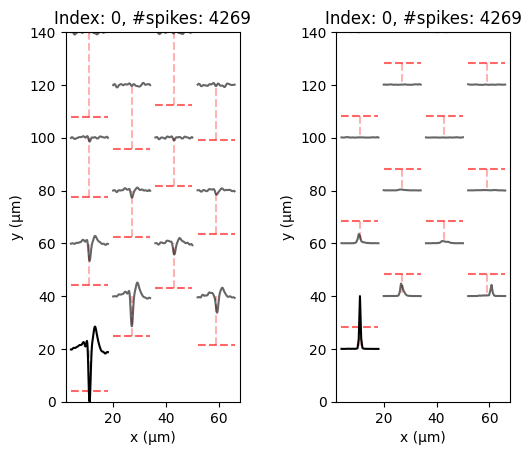

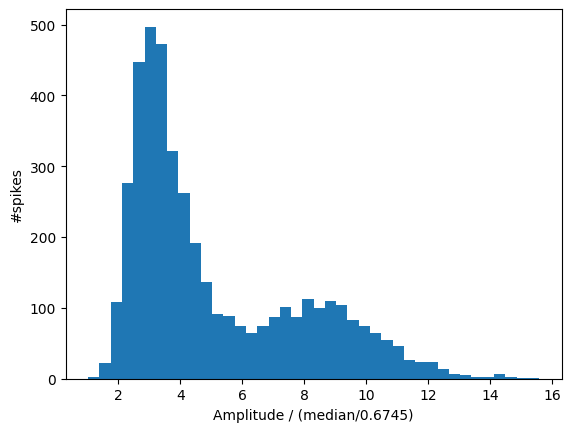

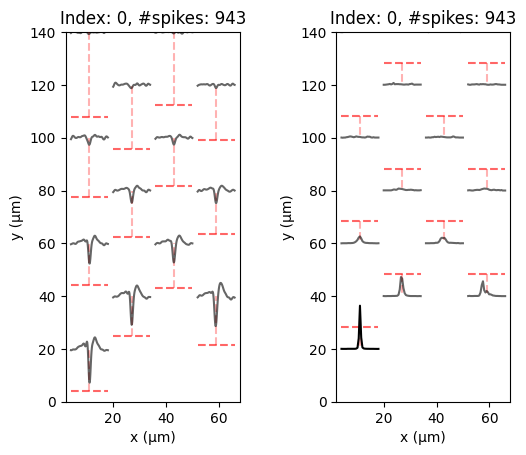

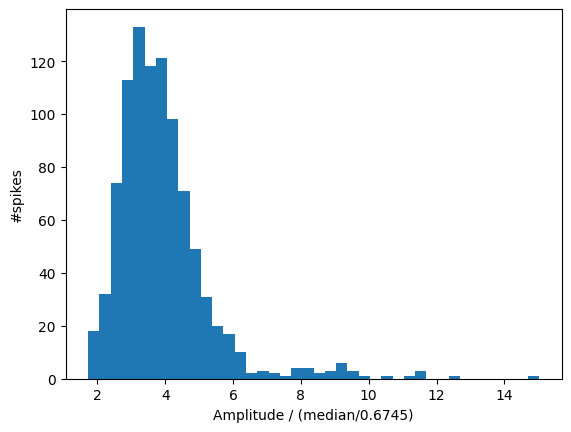

In [ ]:
amp_kwargs = prob_kwargs = None
for m in merges[::-1]:
    amp_kwargs, prob_kwargs = F.plot_elec_probs(m, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()
    
    F.plot_amp_dist(m, bins=40)
    plt.show()

In [ ]:
F.setup_coc_clusters(merges)
pair = F.Merge(merges[0], merges[1])
pair.summarize()

Latency diff: 1.16. Rel amp diff: 0.33
Amp dist p-value 0.0541


In [ ]:
merges[1].latencies[1]

4

In [ ]:
F.setup_coc_clusters(merges)

#### Assigning spikes before or after merging?

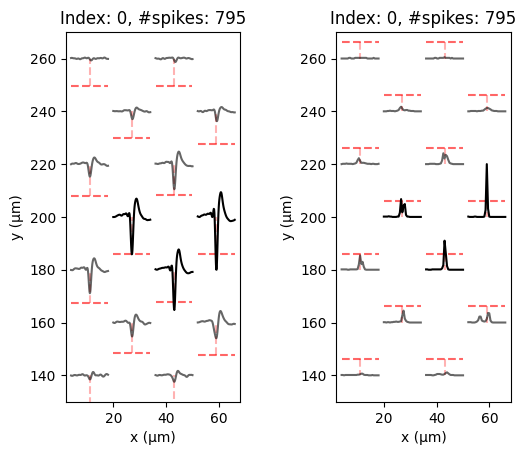

795


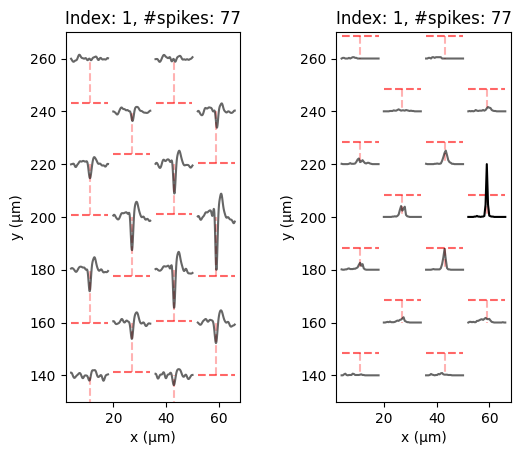

In [ ]:
intra_only = set(intra_merges[0].spike_train).difference(merges[0].spike_train)
unit = Unit(0, list(intra_only), 17, RECORDING)
F.plot_elec_probs(unit)
plt.show()

inter_only = set(merges[0].spike_train).difference(intra_merges[0].spike_train)
unit = Unit(1, list(inter_only), 17, RECORDING)
F.plot_elec_probs(unit)
plt.show()


In [ ]:
intra = deepcopy(merges)
F.assign_spikes(intra, TRAINING_FRAMES, interelec=False, verbose=True)
for m in intra:
    print(len(m.spike_train))

inter = deepcopy(merges)
F.assign_spikes(inter, TRAINING_FRAMES, interelec=True, verbose=True)
for m in inter:
    print(len(m.spike_train))


100%|██████████| 2451452/2451452 [00:10<00:00, 240980.66it/s]


1947
381
2073


100%|██████████| 2451452/2451452 [00:10<00:00, 230100.55it/s]

1942
379
2068


In [ ]:
set(intra[-1].spike_train).difference(inter[-1].spike_train)

### Full run

In [27]:
# Find min_inner_cocs and min_outer_cocs
# for inner, outer in [(1, 2), (1, 3), (2, 3), (2, 4)]:
#     all_sequences = F.get_sequences_parallel(TRAINING_FRAMES, min_inner_coacs=inner, min_outer_coacs=outer)
#     print(len(all_sequences))
#     F.save_sequences_plots(all_sequences, Path(f"/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231124/{inner}_{outer}"))

all_sequences = F.get_sequences_parallel(TRAINING_FRAMES)
print(len(all_sequences))

  4%|▎         | 9/248 [07:21<3:15:28, 49.07s/it]Process ForkPoolWorker-35:
Process ForkPoolWorker-38:
Process ForkPoolWorker-39:
Process ForkPoolWorker-28:
Process ForkPoolWorker-26:
Process ForkPoolWorker-31:
Traceback (most recent call last):
Process ForkPoolWorker-40:
Process ForkPoolWorker-25:
Process ForkPoolWorker-30:
Process ForkPoolWorker-21:
Process ForkPoolWorker-29:
Process ForkPoolWorker-22:
Process ForkPoolWorker-34:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Process ForkPoolWorker-32:
Process ForkPoolWorker-33:
Process ForkPoolWorker-36:
Process ForkPoolWorker-23:
Process ForkPoolWorker-37:
Process ForkPoolWorker-27:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/mea/anaconda3/envs/prop/lib/pyth

KeyboardInterrupt: 

In [ ]:
new_all_sequences = []
for seq in all_sequences:
    new_all_sequences.append(F.CocCluster.convert_old_to_new(seq))

In [25]:
# Interelec merging
all_sequences_merged = F.merge_sequences(new_all_sequences, verbose=True)

Starting with 559 partial sequences
0


/data/MEAprojects/PropSignal/src/run_alg/si_rec7.py:559: RuntimeWarning: invalid value encountered in true_divide
  return elec_probs / np.sum(elec_probs)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
# Save sequences history


In [88]:
for seq in all_sequences:
    if hasattr(seq, "history"): 
        F._save_sequences_plots((seq, Path("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231125")))
        break

In [ ]:
all_sequences = F.clusters_to_clusters(all_sequences)

In [ ]:
# utils.pickle_dump(all_sequences, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/all_sequences_dip_test.pickle")
all_sequences = utils.pickle_load("/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/all_sequences_dip_test.pickle")    
# all_sequences = F.setup_coc_clusters_parallel(all_sequences)

In [ ]:
all_spike_times_curated = []
for seq in all_sequences:
    all_spike_times_curated.extend(seq.spike_train)
all_spike_times_curated = np.sort(all_spike_times_curated)

matches = Comparison.count_matching_events(all_spike_times_curated, ks_spikes)
print(f"#matches/#rt_sort: {matches/len(all_spike_times_curated)*100:.1f}")
print(f"#matches/#kilosort: {matches/len(ks_spikes)*100:.1f}")

#matches/#rt_sort: 46.2
#matches/#kilosort: 87.8


In [ ]:
all_merged_sequences = F.merge_coc_clusters(all_sequences, max_root_elec_dist=50,
                                            auto_setup_coc_clusters=False,
                                            verbose=True)

In [ ]:
# utils.pickle_dump(all_merged_sequences, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/all_merged_sequences_dip_test.pickle")

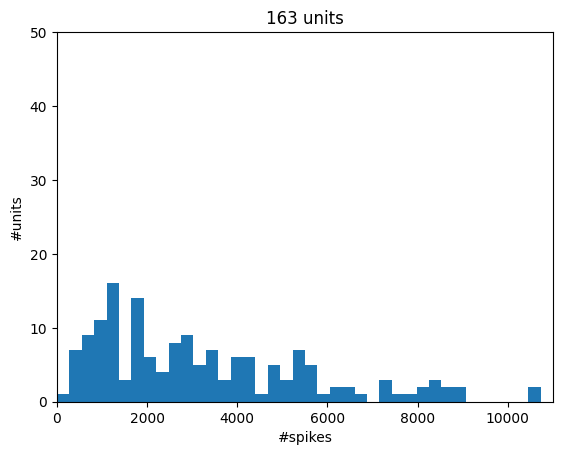

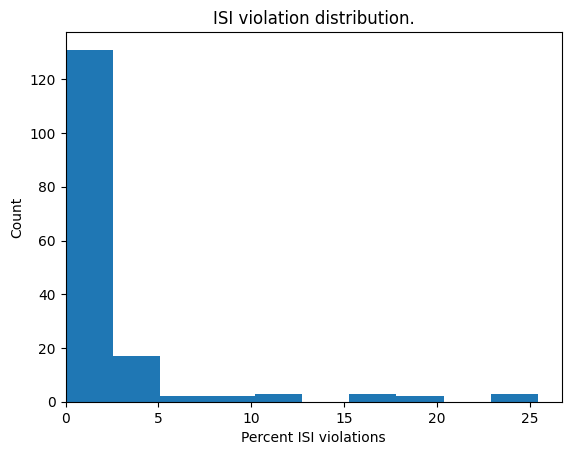

In [ ]:
prop_signal = F.clusters_to_sorter(all_merged_sequences)
prop_signal.plot_nums_spikes()
plt.show()
prop_signal.plot_isis()
plt.show()

100%|██████████| 163/163 [00:09<00:00, 16.92it/s]


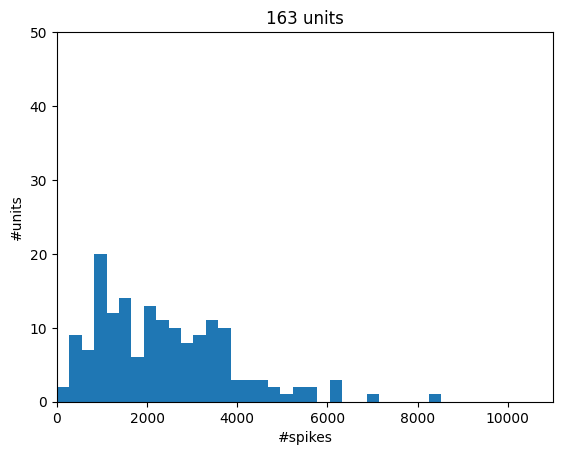

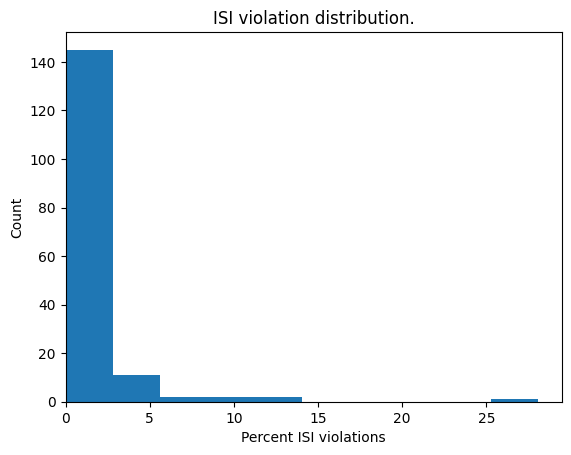

In [ ]:
# This probably isn't needed (maybe it is though)
F.assign_spikes(all_merged_sequences, TRAINING_FRAMES, interelec=True,
                overlap_time=0.1, verbose=True)
all_merged_sequences = F.setup_coc_clusters_parallel(F.clusters_to_clusters(all_merged_sequences))
prop_signal = F.clusters_to_sorter(all_merged_sequences)
prop_signal.plot_nums_spikes()
plt.show()
prop_signal.plot_isis()
plt.show()

### Further development

In [ ]:
for s, seq in enumerate(all_trained_sequences):
    # If seq is Unit obj
    seq.recording = RECORDING
    seq.root_elecs = [seq.chan]
    seq._spike_train = seq.spike_train
    
    isi = F.get_isi_viol_p(seq)
    if isi > 20:
        print(s)
        
        F.plot_elec_probs(seq, idx=s)
        plt.show()
        
        F.plot_amp_dist(seq, bins=40)
        plt.show()
        
        print(F.get_isi_viol_p(seq))

In [ ]:
isi_violators = [cluster for cluster in all_trained_sequences if F.get_isi_viol_p(cluster) > 2]
for s, cluster in enumerate(isi_violators):
    if F.get_isi_viol_p(cluster) > 30:
        F.plot_elec_probs(cluster)
        plt.show()
        
        F.plot_amp_dist(cluster, bins=40)
        plt.show()
        
        print(F.get_isi_viol_p(cluster))
        
        break


In [ ]:
for idx in cluster.merge_history:
    clust = all_sequences[idx]
    F.plot_split_amp(clust, 100)
        
    # F.plot_elec_probs(clust)
    # plt.show()
    # F.plot_amp_dist(clust, bins=40)
    # plt.show()
    # print(F.get_isi_viol_p(clust))
    break

## Assign spikes in test region

In [ ]:
F.assign_spikes(all_merged_sequences, TESTING_FRAMES, interelec=True,
                overlap_time=0.1,
                verbose=True)

100%|██████████| 2227701/2227701 [07:54<00:00, 4696.73it/s]


### Further development

In [ ]:
for s, seq in enumerate(all_merged_sequences):
    # If seq is Unit obj
    # seq.recording = RECORDING
    # seq.root_elecs = [seq.chan]
    # seq._spike_train = seq.spike_train
    
    isi = F.get_isi_viol_p(seq)
    if isi > 2:
        isis = np.diff(seq.spike_train)
        plt.hist(isis, bins=40, range=(0, 5))
        plt.xlim(0, 5)
        plt.show()
        
        
        
        # F.plot_elec_probs(seq, idx=s)
        # plt.show()
        
        # F.plot_amp_dist(seq, bins=40)
        # plt.show()
        
        # print(F.get_isi_viol_p(seq))

In [ ]:
for seq in all_merged_sequences:
    F.plot_elec_probs(seq)
    plt.show()

## Save to file

In [ ]:
prop_signal = F.clusters_to_sorter(all_merged_sequences)
prop_signal.recording = None
utils.pickle_dump(prop_signal, "/data/MEAprojects/dandi/000034/sub-mouse412804/dl_model/rt_sort/231107/2.pickle")

In [ ]:
# quick and dirty, find #overlaps
OVERLAP_TIME = 0.034

all_spikes = []
for s in all_trained_sequences:
    all_spikes.extend(s.spike_train)
all_spikes = np.sort(all_spikes)

count = 0
for i in range(1, len(all_spikes)):
    if all_spikes[i] - all_spikes[i-1] <= OVERLAP_TIME:
        count += 1
print(count)
print(count / len(all_spikes) * 100)

25042
6.761839699953827


## Compare to kilosort
For development and testing

### Setup

In [ ]:
%autoreload 2
from src.comparison import Comparison
from src.sorters.base import SpikeSorter
from src.sorters.kilosort import get_experts_kilosort

In [ ]:
# kilosort = Kilosort(utils.PATH_SM4_SI, "first", RECORDING)
kilosort = get_experts_kilosort()

# Only use spikes in TESTING_FRAMES
start_ms, end_ms = TESTING_FRAMES
spike_times = []
for times in kilosort.get_spike_times():
    times_ind = start_ms <= times
    times_ind *= times <= end_ms
    spike_times.append(times[times_ind])
    
kilosort = SpikeSorter(
    RECORDING,
    name="Experts Kilosort",
    spike_times=spike_times
)

# Create all_ks_units with self.templates and self.chan set --> Don't run this if already ran before
all_ks_units = []

def job(idx):
    unit = Unit(idx, all_ks_spike_times[idx], -1, RECORDING)
    templates = unit.get_templates()
    unit.templates = templates
    unit.recording = None
    unit.chan = np.argmin(np.min(templates, axis=1))
    unit.root_elecs = [unit.chan]
    return unit

all_ks_spike_times = kilosort.get_spike_times()
with Pool(processes=20) as pool:
    tasks = range(len(all_ks_spike_times))
    for unit in tqdm(pool.imap(job, tasks), total=len(tasks)):
        unit.recording = RECORDING
        all_ks_units.append(unit)
        
chan_to_ks_units = {}
for unit in all_ks_units:
    if unit.chan not in chan_to_ks_units:
        chan_to_ks_units[unit.chan] = [unit]
    else:
        chan_to_ks_units[unit.chan].append(unit)

/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/home/mea/anaconda3/envs/prop/lib/python3.7/site-packages/hdmf/spec/namespace.py:456: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/data/MEAprojects/PropSignal/src/sorters/kilosort.py:186: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  spike_times = np.array([spikes1[idx] for idx in range(len(comp.match12)) if comp.match12[idx] != -1])


Recording does not have scaled traces. Setting gain to 0.195


Process ForkPoolWorker-452:
Process ForkPoolWorker-466:
Process ForkPoolWorker-465:
Exception ignored in: <function _releaseLock at 0x7f059b851e60>
Traceback (most recent call last):
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt
Process ForkPoolWorker-463:
Process ForkPoolWorker-467:
Process ForkPoolWorker-464:
Process ForkPoolWorker-462:
Process ForkPoolWorker-459:
Process ForkPoolWorker-458:
Process ForkPoolWorker-457:
Process ForkPoolWorker-455:
Process ForkPoolWorker-461:
Process ForkPoolWorker-456:
Process ForkPoolWorker-460:
Process ForkPoolWorker-453:
Process ForkPoolWorker-454:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/mea/anaconda3/envs/prop/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most 

KeyboardInterrupt: 

### Start comparing

In [ ]:
ks_units = chan_to_ks_units[0]
##
print(len(ks_units))

2


In [ ]:
for unit in ks_units:   
    amp_kwargs, prob_kwargs = F.plot_elec_probs(unit, amp_kwargs=amp_kwargs, prob_kwargs=prob_kwargs)
    plt.show()
    
    F.plot_amp_dist(unit, bins=40)
    plt.show()

In [ ]:
rt_spikes = []
for m in merges:
    rt_spikes.extend(m.spike_train)
rt_spikes = np.sort(rt_spikes)

ks_spikes = []
for k in ks_units:
    ks_spikes.extend(k.spike_train)
ks_spikes = np.sort(ks_spikes)
    
matches = Comparison.count_matching_events(rt_spikes, ks_spikes)
print(f"#matches/#rt_sort: {matches/len(rt_spikes)*100:.1f}")
print(f"#matches/#kilosort: {matches/len(ks_spikes)*100:.1f}")

In [ ]:
rt = SpikeSorter(RECORDING, "RT-Sort", units=merges)
ks = SpikeSorter(RECORDING, "Kilosort", units=ks_units)

comp = Comparison(rt, ks, score_formula=2)
comp.summary()
comp.plot_line_comps()